# zipline MeanReversion Backtest

In the chapter 04, we introduced `zipline` to simulate the computation of alpha factors from trailing cross-sectional market, fundamental, and alternative data. 

Now we will exploit the alpha factors to derive and act on buy and sell signals using the custom MeanReversion factor developed in the last chapter.

## Using Zipline

This notebook uses the `conda` environnment `ml4t-zipline`.

Please follow the instructions provided [here](../../installation/).

> Note: before the first run, you have to install `pyfolio` using `pip` by uncommenting and executing the following cell:

In [21]:
#! pip install "pyfolio==0.5.1"

## Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
import numpy as np
import pandas as pd
from pytz import UTC

from logbook import (NestedSetup, NullHandler, Logger, StreamHandler, StderrHandler, 
                     INFO, WARNING, DEBUG, ERROR)

from zipline import run_algorithm
from zipline.api import (attach_pipeline, 
                         date_rules, 
                         time_rules,
                         get_datetime,
                         order_target_percent,
                         pipeline_output, 
                         record, 
                         schedule_function, 
                         get_open_orders, 
                         calendars,
                         set_commission, 
                         set_slippage)
from zipline.finance import commission, slippage
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.factors import Returns, AverageDollarVolume

from pyfolio.utils import extract_rets_pos_txn_from_zipline

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('whitegrid')

## Logging Setup

In [4]:
# setup stdout logging
format_string = '[{record.time: %H:%M:%S.%f}]: {record.level_name}: {record.message}'
zipline_logging = NestedSetup([NullHandler(level=DEBUG),
                               StreamHandler(sys.stdout, format_string=format_string, level=INFO),
                               StreamHandler(sys.stderr, level=ERROR)])
zipline_logging.push_application()
log = Logger('Algorithm')

## Algo Settings

In [5]:
# Settings
MONTH = 21
YEAR = 12 * MONTH
N_LONGS = 50
N_SHORTS = 50
VOL_SCREEN = 500

In [6]:
start = pd.Timestamp('2013-01-01', tz=UTC)
end = pd.Timestamp('2017-01-01', tz=UTC)
capital_base = 1e7

## Mean Reversion Factor

In [7]:
class MeanReversion(CustomFactor):
    """Compute ratio of latest monthly return to 12m average,
       normalized by std dev of monthly returns"""
    inputs = [Returns(window_length=MONTH)]
    window_length = YEAR

    def compute(self, today, assets, out, monthly_returns):
        df = pd.DataFrame(monthly_returns)
        out[:] = df.iloc[-1].sub(df.mean()).div(df.std())

## Create Pipeline

The Pipeline created by the `compute_factors()` method returns a table with a long and a short column for the 25 stocks with the largest negative and positive deviations of their last monthly return from its annual average, normalized by the standard deviation. It also limited the universe to the 500 stocks with the highest average trading volume over the last 30 trading days. 

In [8]:
def compute_factors():
    """Create factor pipeline incl. mean reversion,
        filtered by 30d Dollar Volume; capture factor ranks"""
    mean_reversion = MeanReversion()
    dollar_volume = AverageDollarVolume(window_length=30)
    return Pipeline(columns={'longs'  : mean_reversion.bottom(N_LONGS),
                             'shorts' : mean_reversion.top(N_SHORTS),
                             'ranking': mean_reversion.rank(ascending=False)},
                    screen=dollar_volume.top(VOL_SCREEN))

Before_trading_start() ensures the daily execution of the pipeline and the recording of the results, including the current prices.

In [9]:
def before_trading_start(context, data):
    """Run factor pipeline"""
    context.factor_data = pipeline_output('factor_pipeline')
    record(factor_data=context.factor_data.ranking)
    assets = context.factor_data.index
    record(prices=data.current(assets, 'price'))

## Set up Rebalancing

The new rebalance() method submits trade orders to the exec_trades() method for the assets flagged for long and short positions by the pipeline with equal positive and negative weights. It also divests any current holdings that are no longer included in the factor signals:

In [10]:
def rebalance(context, data):
    """Compute long, short and obsolete holdings; place trade orders"""
    factor_data = context.factor_data
    assets = factor_data.index
    
    longs = assets[factor_data.longs]
    shorts = assets[factor_data.shorts]
    divest = context.portfolio.positions.keys() - longs.union(shorts)
    log.info('{} | Longs: {:2.0f} | Shorts: {:2.0f} | {:,.2f}'.format(get_datetime().date(),
                                                                     len(longs), 
                                                                     len(shorts),
                                                                     context.portfolio.portfolio_value))

    exec_trades(data, assets=divest, target_percent=0)
    exec_trades(data, assets=longs, target_percent=1 / N_LONGS if N_LONGS else 0)
    exec_trades(data, assets=shorts, target_percent=-1 / N_SHORTS if N_SHORTS else 0)

In [11]:
def exec_trades(data, assets, target_percent):
    """Place orders for assets using target portfolio percentage"""
    for asset in assets:
        if data.can_trade(asset) and not get_open_orders(asset):
            order_target_percent(asset, target_percent)

## Initialize Backtest

The `rebalance()` method runs according to `date_rules` and `time_rules` set by the `schedule_function()` utility at the beginning of the week, right after market_open as stipulated by the built-in US_EQUITIES calendar (see docs for details on rules). 

You can also specify a trade commission both in relative terms and as a minimum amount. There is also an option to define slippage, which is the cost of an adverse change in price between trade decision and execution

In [12]:
def initialize(context):
    """Setup: register pipeline, schedule rebalancing,
        and set trading params"""
    attach_pipeline(compute_factors(), 'factor_pipeline')
    schedule_function(rebalance,
                      date_rules.week_start(),
                      time_rules.market_open(),
                      calendar=calendars.US_EQUITIES)

    set_commission(us_equities=commission.PerShare(cost=0.00075, 
                                                   min_trade_cost=.01))
    set_slippage(us_equities=slippage.VolumeShareSlippage(volume_limit=0.0025, 
                                                          price_impact=0.01))

## Run Algorithm

The algorithm executes upon calling the run_algorithm() function and returns the backtest performance DataFrame.

In [13]:
backtest = run_algorithm(start=start,
                         end=end,
                         initialize=initialize,
                         before_trading_start=before_trading_start,
                         bundle='quandl',
                         capital_base=capital_base)

[ 06:09:06.768620]: WARNING: Refusing to download new benchmark data because a download succeeded at 2021-01-21 05:56:29.993739+00:00.
[ 06:09:06.800008]: WARNING: Refusing to download new treasury data because a download succeeded at 2021-01-21 05:56:31.357739+00:00.
[ 06:09:07.895359]: INFO: 2013-01-07 | Longs: 10 | Shorts:  2 | 10,000,000.00
[ 06:09:09.220597]: INFO: 2013-01-14 | Longs: 13 | Shorts:  3 | 10,027,422.36
[ 06:09:09.432374]: INFO: 2013-01-22 | Longs:  8 | Shorts:  5 | 10,097,663.57
[ 06:09:09.608787]: INFO: 2013-01-28 | Longs:  5 | Shorts: 14 | 10,106,150.06
[ 06:09:09.823626]: INFO: 2013-02-04 | Longs: 12 | Shorts: 11 | 10,135,417.26
[ 06:09:10.045621]: INFO: 2013-02-11 | Longs: 11 | Shorts: 13 | 10,182,644.42
[ 06:09:10.271114]: INFO: 2013-02-19 | Longs: 21 | Shorts: 11 | 10,127,755.45
[ 06:09:10.464548]: INFO: 2013-02-25 | Longs: 16 | Shorts:  8 | 10,180,357.23
[ 06:09:10.699346]: INFO: 2013-03-04 | Longs: 10 | Shorts: 10 | 10,200,300.19
[ 06:09:10.917862]: INFO: 201

[ 06:09:33.603269]: INFO: 2014-12-22 | Longs:  7 | Shorts:  4 | 10,162,433.56
[ 06:09:33.779226]: INFO: 2014-12-29 | Longs: 10 | Shorts:  8 | 10,153,178.89
[ 06:09:33.955773]: INFO: 2015-01-05 | Longs:  6 | Shorts:  3 | 10,058,855.77
[ 06:09:34.165601]: INFO: 2015-01-12 | Longs:  7 | Shorts:  6 | 10,013,742.96
[ 06:09:35.233478]: INFO: 2015-01-20 | Longs: 12 | Shorts:  7 | 9,911,930.16
[ 06:09:35.412547]: INFO: 2015-01-26 | Longs: 11 | Shorts:  8 | 9,933,179.35
[ 06:09:35.640710]: INFO: 2015-02-02 | Longs: 18 | Shorts:  7 | 9,874,894.91
[ 06:09:35.868048]: INFO: 2015-02-09 | Longs: 15 | Shorts:  6 | 10,026,955.51
[ 06:09:36.095888]: INFO: 2015-02-17 | Longs: 12 | Shorts: 11 | 10,080,570.15
[ 06:09:36.282111]: INFO: 2015-02-23 | Longs: 13 | Shorts:  7 | 10,087,564.34
[ 06:09:36.507680]: INFO: 2015-03-02 | Longs: 16 | Shorts:  7 | 10,042,612.79
[ 06:09:36.733731]: INFO: 2015-03-09 | Longs: 12 | Shorts:  5 | 9,963,112.34
[ 06:09:36.954200]: INFO: 2015-03-16 | Longs: 15 | Shorts:  2 | 10,0

[ 06:09:59.125116]: INFO: 2016-12-12 | Longs: 21 | Shorts:  1 | 10,835,582.73
[ 06:09:59.357802]: INFO: 2016-12-19 | Longs: 13 | Shorts:  2 | 10,871,411.67
[ 06:09:59.577485]: INFO: 2016-12-27 | Longs: 12 | Shorts:  1 | 10,815,943.67
[ 06:09:59.717174]: INFO: Simulated 1008 trading days
first open: 2013-01-02 14:31:00+00:00
last close: 2016-12-30 21:00:00+00:00


## Extract pyfolio Inputs

The `extract_rets_pos_txn_from_zipline` utility provided by `pyfolio` extracts the data used to compute performance metrics.

In [14]:
returns, positions, transactions,_ = extract_rets_pos_txn_from_zipline(backtest)

## Persist Results for use with `pyfolio`

In [15]:
with pd.HDFStore('backtests.h5') as store:
    store.put('backtest/equal_weight', backtest)
    store.put('returns/equal_weight', returns)
    store.put('positions/equal_weight', positions)
    store.put('transactions/equal_weight', transactions)

## Plot Results

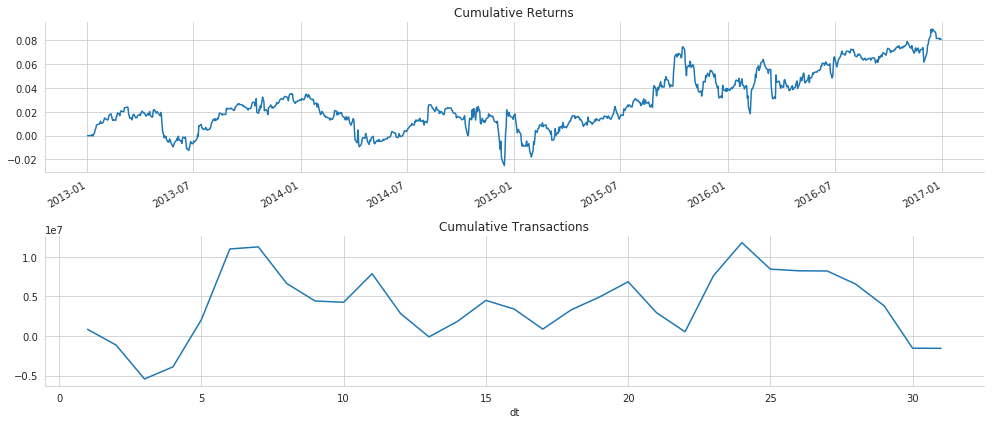

In [16]:
fig, axes= plt.subplots(nrows=2, figsize=(14,6))
returns.add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Returns')
transactions.groupby(transactions.dt.dt.day).txn_dollars.sum().cumsum().plot(ax=axes[1], title='Cumulative Transactions')
fig.tight_layout()
sns.despine();

In [17]:
positions.index = positions.index.date

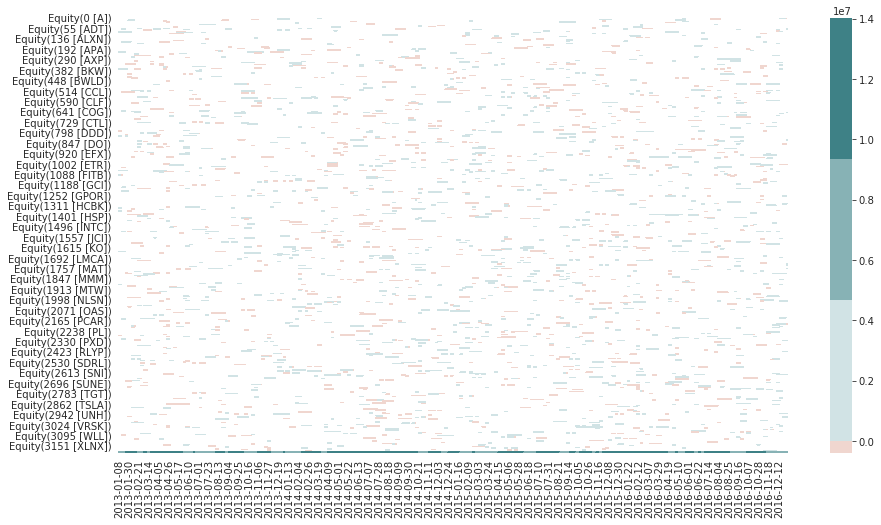

In [18]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(positions.replace(0, np.nan).dropna(how='all', axis=1).T, 
            cmap=sns.diverging_palette(h_neg=20, h_pos=200), ax=ax, center=0);

In [19]:
positions.head()

,Equity(0 [A]),Equity(1 [AA]),Equity(2 [AAL]),Equity(7 [AAP]),Equity(8 [AAPL]),Equity(12 [ABBV]),Equity(13 [ABC]),Equity(20 [ABT]),Equity(21 [ACAD]),Equity(27 [ACE]),...,Equity(3156 [XOM]),Equity(3162 [XPO]),Equity(3165 [XRX]),Equity(3171 [YELP]),Equity(3172 [YHOO]),Equity(3175 [YUM]),Equity(3180 [ZBH]),Equity(3194 [ZNGA]),Equity(3197 [ZTS]),cash
2013-01-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.441446e+06
2013-01-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.379079e+06
2013-01-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.379079e+06
2013-01-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.379079e+06
2013-01-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.379079e+06


In [20]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6505 entries, 2013-01-08 21:00:00+00:00 to 2016-12-30 21:00:00+00:00
Data columns (total 8 columns):
amount         6505 non-null int64
commission     0 non-null object
dt             6505 non-null datetime64[ns, UTC]
order_id       6502 non-null object
price          6505 non-null float64
sid            6505 non-null object
symbol         6505 non-null object
txn_dollars    6505 non-null float64
dtypes: datetime64[ns, UTC](1), float64(2), int64(1), object(4)
memory usage: 457.4+ KB
